Copyright (c) 2024 Massachusetts Institute of Technology

SPDX-License-Identifier: MIT

# Launching a Set of Simulations

So far, we've explored how to use `madlib` to launch a single satellite/sensor simulation at a time. The true power of `MaDDG`, however, is that it allows us to conduct large-scale experiments with randomly varied parameters.

This notebook will walk through the following steps to launching a custom batch of simulation experiments:
1) Defining the experiment parameters,
2) Preparing the simulator task function, and 
3) Launching the experiments in parallel.
4) Analyzing the results

## Defining the Experiment Parameters

Each simulation involves a network of sensors observing a satellite, and that satellite may or may not be performing a maneuver during the period of observation. The first step to creating our set of simulations is to define these parameters, or at least the distributions from which the parameters will be pulled.

### Creating the Sensor Network

One thing that every simulation in our set will have in common is that they will all use the same sensor network. `MaDDG` comes packaged with a sample network (`configs/sample_sensor_network.yaml`) that offers good global coverage of the GEO belt. Let's go ahead and use that.

All we need to do is point our code to the YAML file containing the sensor parameters. To better understand these parameters, refer to the Example 3 notebook on sensor collections.

In [1]:
from pathlib import Path

sensor_yaml = Path("../configs/sample_sensor_network.yaml")

### Creating the Satellite Distributions

While we will create the `Satellite` objects themselves (including their orbital parameters) within the simulator task function, we can define the types and vector distributions of their maneuvers now. That way, each separate experiment can create a unique satellite, but they will all have the same general class of behavior.

For this example, we'll consider impulsive maneuvers with in-track and cross-track components.

In [2]:
# First, define the maneuver type as a string ("impulse", "continuous", or "all")
mtype = "impulse"

# The vector components of the thrust vector will be pulled from normal distributions, the mean and width of which we define here.
# The values are entered as a 3-element list with the radial, in-track, and cross-track components of the delta-v (respectively)
# in km/s.
dv_ric_mean_kms = (0.0, 0.0, 0.0)
dv_ric_std_kms = (0.0, 0.1, 1.0)

### Defining the Experiment Timing

We can control the time and day of the simulated epoch at which our experiments will start, as well as the simulated duration of the experiments. For this example, we'll use the arbitrary date of 60197.5 (again, all dates are in MJD format!). For the simulation duration, we'll go with 3 days.

In [3]:
start_mjd = 60197.5
sim_duration_days = 3.0  # Duration is defined in days

### Defining the Number of Simulations and Launch Controls

The next thing we need to do is decide how many unique simulations to run. Note that we define this as a number of pairs: each pair contains one maneuvering and one non-maneuvering satellite (with different orbital parameters). This is designed to give us a balanced dataset for classification tasks.

We'll keep this example lightweight and run 5 pairs of simulations, for a total of 10.

In [4]:
num_sim_pairs = 5

Finally, we need to figure out where the outputs of our simulations will go, and if we want to run them in parallel. Since we're running 100 simulations, parallelizing them will be a good idea. Luckily, the [submitit](https://hydra.cc/docs/plugins/submitit_launcher/) plugin for [hydra](https://hydra.cc/) (both of which are installed with this project) makes it easy to distribute jobs across available CPUs.

Feel free to change the output directory in this example, but the one that we'll create is already added to the project's `.gitignore`, so it shouldn't cause any issues.

In [5]:
# Create the output directory
output_path = "example_outputs"
output_dir = Path(output_path)
output_dir.mkdir(exist_ok=True)

The multirun directory is where hydra-zen saves experiment files. We'll put it under `example_outputs/`. We can raise a flag to automatically delete the multirun directory when the jobs are complete, but we'll preserve them this time for illustrative purposes.

In [6]:
multirun_dir = output_dir / "multirun"
multirun_path = str(multirun_dir)  # We need the string version of this path

rm_multirun_root = (
    False  # If True, multirun directories created by this job will be deleted
)

Finally, we need a configuration JSON to tell `MaDDG` to use the `submitit` plugin to parallelize the job. We just want to run locally, so we'll set the hydra launcher to `submitit_local`.

We'll also set the option `hydra.job.chdir` to `True` to make sure the outputs of each simulation are saved to their own respective multirun directories.

In [7]:
import json

submitit_json = [
    "hydra.job.chdir=True",
    "hydra/launcher=submitit_local",
    "hydra.launcher.nodes=1",
    "hydra.launcher.cpus_per_task=2",
    "hydra.launcher.tasks_per_node=10",
    "hydra.launcher.mem_gb=16",
]

submitit_file = Path("example_outputs") / "submitit.json"
with open(submitit_file, "w") as f:
    json.dump(submitit_json, f)

## Preparing the Simulator Task Function

The task function is a concept borrowed from [hydra-zen](https://mit-ll-responsible-ai.github.io/hydra-zen/index.html), and it's the actual code that will be run for each simulation. Our task function should instantiate the sensor network and random satellite, propagate the orbit and record observations throughout the simulation duration, compute metrics on the produced observations, and return those metrics as a [pandas](https://pandas.pydata.org/) DataFrame. `MaDDG` will automatically collate all of the DataFrames created by the experiments and produce a single CSV as our final output.

Our task function must accept the following input parameters:
- `seq_id` - An integer ID for the experiment
- `sensor_params` - A dictionary containing the parameters for each sensor in our network
- `maneuver_type` - An integer defining the type of maneuver for the satellite (0=None, 1=Impulsive, 2=Continuous)
- `sim_duration_days` - A float defining the length of the simulation in days
- `start_mjd` - A float (or None, as discussed above) defining the simulation's starting epoch in MJD format
- `dv_ric_mean_kms` - A tuple of 3 floats defining the means of the thrust vector distributions (see "Creating the Satellite Distributions" above)
- `dv_ric_std_kms` - Same as `dv_ric_mean_kms`, but for the distribution widths

Our simulation task is to calculate **residuals**, the differences between the satellite's expected position and its actual position at each observation time.

In [8]:
from typing import Tuple

In [9]:
import madlib
from maddg._residuals import calculate_residuals
import numpy as np


def simulator_task(
    seq_id: int,
    sensor_params: dict,
    maneuver_type: int,
    sim_duration_days: float,
    start_mjd: float,
    dv_ric_mean_kms: Tuple[float, float, float],
    dv_ric_std_kms=Tuple[float, float, float],
    **kwargs,
):
    # Define a SensorCollection object from the given parameters
    sensors = [madlib.GroundOpticalSensor(**params) for key, params in sensor_params.items()]
    sensor_network = madlib.SensorCollection(sensors)

    # Timing
    epoch = start_mjd

    # Create the satellite (a GEO object at a random longitude)
    sat_longitude = 360 * np.random.random()
    sat_observed = madlib.Satellite.from_GEO_longitude(sat_longitude, epoch)

    maneuver = None
    maneuver_mjd = None
    maneuver_r_kms = None
    maneuver_i_kms = None
    maneuver_c_kms = None

    # For maneuvering cases, create a random maneuver vector
    if maneuver_type == 1:
        # Pick a random maneuver time during the simulation
        maneuver_mjd = epoch + sim_duration_days * np.random.random()

        # Calculate the thrust vector using the input distributions
        mean_rad, mean_in, mean_crs = dv_ric_mean_kms
        std_rad, std_in, std_crs = dv_ric_std_kms

        maneuver_r_kms = mean_rad + std_rad * np.random.randn()
        maneuver_i_kms = mean_in + std_in * np.random.randn()
        maneuver_c_kms = mean_crs + std_crs * np.random.randn()

        # Define the ImpulsiveManeuver object, converting from km/s to m/s
        man_dv = np.array([maneuver_r_kms, maneuver_i_kms, maneuver_c_kms]) / 1000
        maneuver = madlib.ImpulsiveManeuver(maneuver_mjd, man_dv)

    sat_observed.maneuver = maneuver

    # Observe and calculate residuals
    residual_df = calculate_residuals(
        sensors=sensor_network,
        satellite=sat_observed,
        sim_duration_days=sim_duration_days,
        t_start_mjd=epoch,
    )

    # Append maneuver information to the output dataframe
    if residual_df is not None:
        residual_df["Maneuver"] = maneuver_type
        residual_df["Sequence"] = int(seq_id)
        residual_df["Maneuver_MJD"] = maneuver_mjd
        residual_df["Maneuver_DV_Radial_KmS"] = maneuver_r_kms
        residual_df["Maneuver_DV_InTrack_KmS"] = maneuver_i_kms
        residual_df["Maneuver_DV_CrossTrack_KmS"] = maneuver_c_kms

    # Return the requisite dataframe
    return residual_df

## Launching the Experiments
Next we use the `MaDDG` launcher to run the simulations we've defined in the manner we've configured. There are several inputs to this function, many of which are optional or exclusive to continuous maneuver cases. We encourage you to read the function's documentation for a full explanation of the arguments.

For now, we introduce no parameters that were not discussed above. Executing the cell below will launch the simulations, which may take several minutes to complete depending on your computer's resources.

In [10]:
from maddg._sim_launcher import launcher

launcher(
    simulator_method=simulator_task,
    mtype=mtype,
    num_sim_pairs=num_sim_pairs,
    sensor_yaml=sensor_yaml,
    outdir=output_dir,
    dv_ric_mean_kms=dv_ric_mean_kms,
    dv_ric_std_kms=dv_ric_std_kms,
    submitit=str(submitit_file),
    multirun_root=multirun_path,
    rm_multirun_root=rm_multirun_root,
    start_mjd=start_mjd,
    sim_duration_days=sim_duration_days,
    random_seed=0,
)

INFO :: mtype = 'impulse'
INFO :: sim_duration_days = 3.0
INFO :: sims_per_task = 1
[2024-06-18 16:58:24,003][HYDRA] Submitit 'local' sweep output dir : example_outputs/multirun/2024-06-18/16-58-22
[2024-06-18 16:58:24,005][HYDRA] 	#0 : maneuver_type=0 seq_id=0
[2024-06-18 16:58:24,014][HYDRA] 	#1 : maneuver_type=0 seq_id=1
[2024-06-18 16:58:24,023][HYDRA] 	#2 : maneuver_type=0 seq_id=2
[2024-06-18 16:58:24,034][HYDRA] 	#3 : maneuver_type=0 seq_id=3
[2024-06-18 16:58:24,044][HYDRA] 	#4 : maneuver_type=0 seq_id=4
[2024-06-18 16:58:24,053][HYDRA] 	#5 : maneuver_type=1 seq_id=0
[2024-06-18 16:58:24,062][HYDRA] 	#6 : maneuver_type=1 seq_id=1
[2024-06-18 16:58:24,071][HYDRA] 	#7 : maneuver_type=1 seq_id=2
[2024-06-18 16:58:24,080][HYDRA] 	#8 : maneuver_type=1 seq_id=3
[2024-06-18 16:58:24,090][HYDRA] 	#9 : maneuver_type=1 seq_id=4


## Explaining the Outputs
Once the jobs have completed, let's stop and take a look at the files that have been produced in our output directory:

- **multirun** directory
    - This will have nested folders named with the date and time that the simulations were launched.
    - Inside the date/time folders will be 10 folders labeled 0-9 and a **.submitit** directory.
    - The **.submitit** folder contains the stderr and stdout of the individual jobs. This is useful for debugging.
    - Each numbered folder contains a **.hydra** folder
        - Inside, you'll find various YAML files describing the configuration of that specific experiment.
    - The numbered folders also contain **zen_launch.log** (a log of the job submissions that can be ignored) and **output.csv**, which holds the measurements from that simulation.
- **complete.csv**
    - This is the final data product, concatenating the results from the individual simulations.
- **errors.txt**
    - If any simulations encountered errors, they will be recorded here.
- **multirun.yaml**
    - Another hydra YAML summarizing the jobs we launched. You can ignore this, but it's a useful summary and can be used to reproduce the experiment in the future.
- **submitit.json**
    - The JSON we created earlier in this notebook to configure the submitit parallellization of our jobs.

## Analyzing the Experiments
Let's take a look at the collated results of our simulations by reading the **complete.csv** file:

In [11]:
import pandas as pd

results = pd.read_csv("example_outputs/complete.csv")
results

,MJD,RA Arcsec,DEC Arcsec,SensorID,Maneuver,Sequence,Maneuver_MJD,Maneuver_DV_Radial_KmS,Maneuver_DV_InTrack_KmS,Maneuver_DV_CrossTrack_KmS
0,60198.111433,0.265156,0.116136,C1,0,0,NaN,NaN,NaN,NaN
1,60198.184929,-2.286885,0.196002,C1,0,0,NaN,NaN,NaN,NaN
2,60198.258424,-1.112096,0.065560,C1,0,0,NaN,NaN,NaN,NaN
3,60198.331920,-0.699248,0.570814,C1,0,0,NaN,NaN,NaN,NaN
4,60198.405415,0.658723,0.124080,C1,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
707,60199.680953,-8.950171,54.328034,B3,1,4,60199.388352,0.0,0.051197,0.742526
708,60199.754449,-16.675548,43.210577,B3,1,4,60199.388352,0.0,0.051197,0.742526
709,60199.827944,-28.241519,21.618071,B3,1,4,60199.388352,0.0,0.051197,0.742526
710,60199.901440,-41.482868,-6.093304,B3,1,4,60199.388352,0.0,0.051197,0.742526


Each row in this table is an osbservation of the satellite, and the columns are described as follows:
- **MJD**: The time of the observation, in MJD format
- **LON Arcsec**: The longitude residual, or the distance between its expected and measured surface longitudes, in arcseconds
- **LAT Arcsec**: The latitude residual, or the distance between its expected and measured surface latitudes, in arcseconds
- **SensorID**: The name of the sensor that collected the observation
- **Maneuver**: 0 if no maneuver was performed, otherwise 1 (remember, all maneuvers are impulsive in this set of simulations)
- **Sequence**: An integer identifier for each unique simulation
- **Maneuver_MJD**:
  - For maneuvering satellites, this is the time that the maneuver occurred, in MJD format.
  - For non-maneuvering cases, this value will be NaN
- **Maneuver_DV_<RIC>_KmS**:
  - For maneuvering cases, these three columns give the delta-v (in km/s) in the radial, in-track, and cross-track directions.
  - For non-maneuvering cases, these values will be NaN

If you examine the code for the task function above (`simulator_task`), you can see how these values were calculated.

<div class="alert alert-block alert-warning">
<b>Note:</b> Due to our method for calculating each simulation's unique ID, the maximum value of the Sequence numbers 
is not necessarily the same as the number of simulations run.
</div>

### Visualizing Results
Let's take a look at some individual scenarios. First, we'll select a non-maneuvering case and look at its residuals over time.

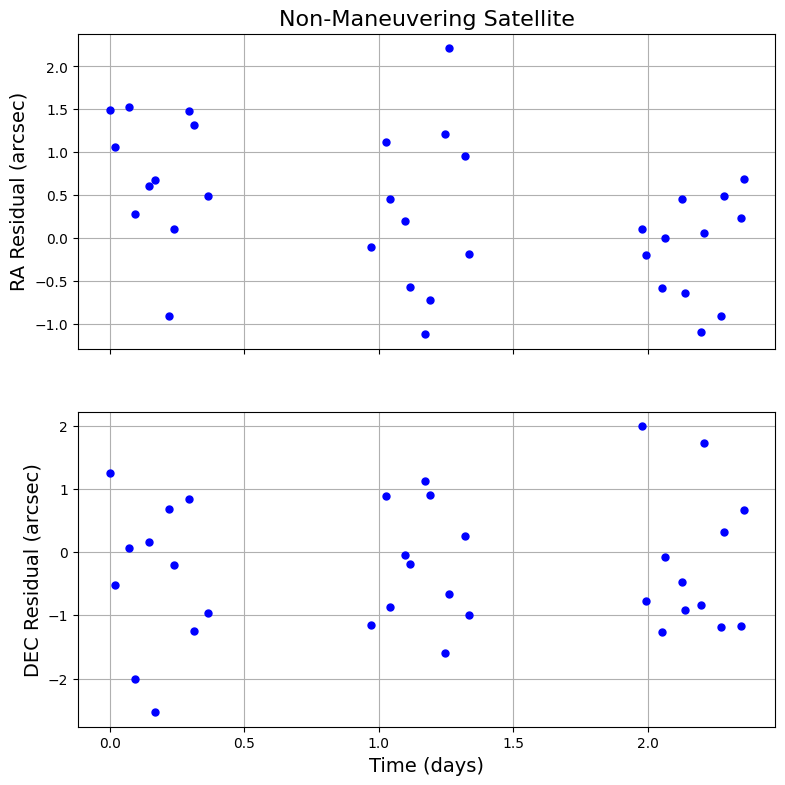

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

data_nomnvr = results.loc[(results["Sequence"]==1) & (results["Maneuver"]==0)]

t = data_nomnvr["MJD"].to_numpy()
t = t-min(t)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(9, 9))
ax1.plot(t, data_nomnvr["RA Arcsec"], "ob", ms=5)
ax2.plot(t, data_nomnvr["DEC Arcsec"], "ob", ms=5)
ax1.grid()
ax2.grid()
ax1.set_ylabel("RA Residual (arcsec)", fontsize=14)
ax2.set_ylabel("DEC Residual (arcsec)", fontsize=14)
ax2.set_xlabel("Time (days)", fontsize=14)
_ = ax1.set_title("Non-Maneuvering Satellite", fontsize=16)

There's some random sensor noise to our observations, but the residuals in both dimensions stay close to 0 on average. This makes perfect sense: This satellite is not maneuvering, so its expected position - defined by its original orbit - should match up with its observed position.

Now let's look at a maneuvering case:

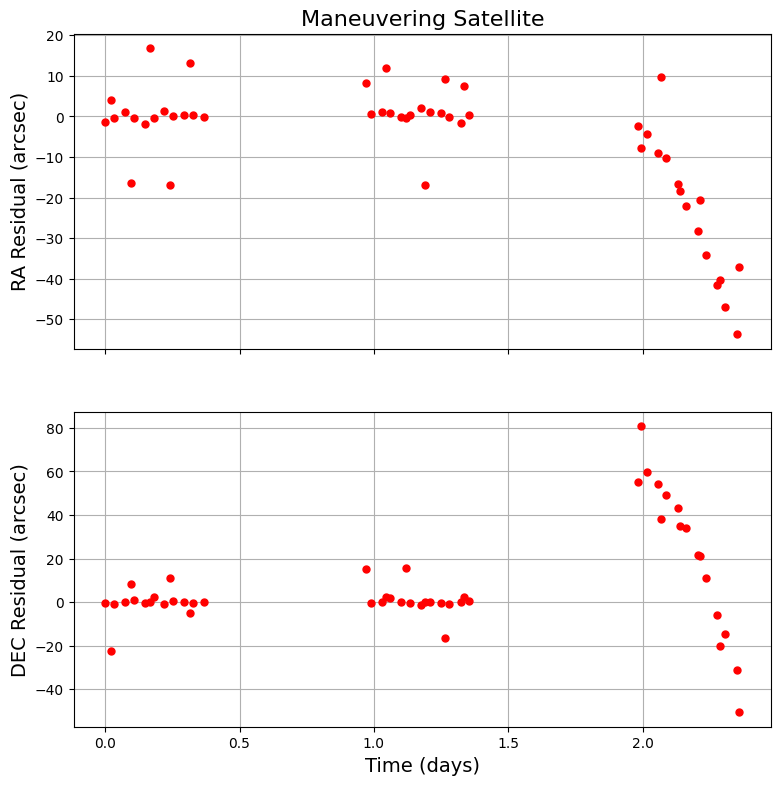

In [14]:
data_mnvr = results.loc[(results["Sequence"] == 4) & (results["Maneuver"] == 1)]

t = data_mnvr["MJD"].to_numpy()
t = t - min(t)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(9, 9))
ax1.plot(t, data_mnvr["RA Arcsec"], "or", ms=5)
ax2.plot(t, data_mnvr["DEC Arcsec"], "or", ms=5)
ax1.grid()
ax2.grid()
ax1.set_ylabel("RA Residual (arcsec)", fontsize=14)
ax2.set_ylabel("DEC Residual (arcsec)", fontsize=14)
ax2.set_xlabel("Time (days)", fontsize=14)
_ = ax1.set_title("Maneuvering Satellite", fontsize=16)

That's quite the difference! The residuals in both dimensions change drastically after the maneuver.

Using `MaDDG` - and some high-performance computing resources - we could easily create thousands of residual curves like this to richly sample a specific class of maneuvers, which is the first step to building trustworthy algorithms for classifying and characterizing maneuvers.